## 1. Import Required Libraries

In [31]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" All libraries imported successfully!")

 All libraries imported successfully!


## 2. Load the Dataset

In [32]:
# Load training and test datasets
train_df = pd.read_csv('/kaggle/input/Patient-Recovery-Prediction-Challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/Patient-Recovery-Prediction-Challenge/test.csv')

print(" Dataset loaded successfully!")
print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


 Dataset loaded successfully!

Training set shape: (8000, 7)
Test set shape: (2000, 6)


## 3. Exploratory Data Analysis (EDA)

### 3.1 Initial Data Inspection

In [33]:
# Display first few rows
print("=" * 80)
print("FIRST 10 ROWS OF TRAINING DATA")
print("=" * 80)
display(train_df.head(10))

FIRST 10 ROWS OF TRAINING DATA


,Id,Therapy Hours,Initial Health Score,Lifestyle Activities,Average Sleep Hours,Follow-Up Sessions,Recovery Index
0,9255,5,49,No,7,5,36
1,1562,2,48,Yes,7,6,25
2,1671,2,81,No,7,2,59
3,6088,2,46,No,6,1,22
4,6670,8,47,No,9,0,40
5,5934,3,56,No,4,4,33
6,8830,3,51,Yes,4,1,30
7,7946,9,93,Yes,5,2,89
8,3509,4,61,Yes,6,5,46
9,2003,4,96,Yes,8,0,83


In [34]:
# Data info
print("=" * 80)
print("DATA INFORMATION")
print("=" * 80)
train_df.info()
print("\n" + "=" * 80)
print("COLUMN NAMES")
print("=" * 80)
print(train_df.columns.tolist())

DATA INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id                    8000 non-null   int64 
 1   Therapy Hours         8000 non-null   int64 
 2   Initial Health Score  8000 non-null   int64 
 3   Lifestyle Activities  8000 non-null   object
 4   Average Sleep Hours   8000 non-null   int64 
 5   Follow-Up Sessions    8000 non-null   int64 
 6   Recovery Index        8000 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 437.6+ KB

COLUMN NAMES
['Id', 'Therapy Hours', 'Initial Health Score', 'Lifestyle Activities', 'Average Sleep Hours', 'Follow-Up Sessions', 'Recovery Index']


In [35]:
# Basic statistics
print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
display(train_df.describe())

DESCRIPTIVE STATISTICS


,Id,Therapy Hours,Initial Health Score,Average Sleep Hours,Follow-Up Sessions,Recovery Index
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,5012.51,4.98,69.53,6.54,4.62,55.31
std,2887.65,2.59,17.34,1.70,2.86,19.20
min,2.00,1.00,40.00,4.00,0.00,10.00
25%,2512.75,3.00,54.75,5.00,2.00,40.00
50%,5014.50,5.00,70.00,7.00,5.00,55.00
75%,7505.25,7.00,85.00,8.00,7.00,71.00
max,10000.00,9.00,99.00,9.00,9.00,100.00


In [36]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES CHECK")
print("=" * 80)
missing_values = train_df.isnull().sum()
print(missing_values)
print(f"\n Total missing values: {missing_values.sum()}")

MISSING VALUES CHECK
Id                      0
Therapy Hours           0
Initial Health Score    0
Lifestyle Activities    0
Average Sleep Hours     0
Follow-Up Sessions      0
Recovery Index          0
dtype: int64

 Total missing values: 0


In [37]:
# Check for duplicates
print("=" * 80)
print("DUPLICATE CHECK")
print("=" * 80)
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

DUPLICATE CHECK
Number of duplicate rows: 0


In [38]:
# Analyze categorical variable
print("=" * 80)
print("LIFESTYLE ACTIVITIES DISTRIBUTION")
print("=" * 80)
lifestyle_counts = train_df['Lifestyle Activities'].value_counts()
print(lifestyle_counts)
print(f"\nPercentage distribution:")
print(train_df['Lifestyle Activities'].value_counts(normalize=True) * 100)

LIFESTYLE ACTIVITIES DISTRIBUTION
Lifestyle Activities
No     4043
Yes    3957
Name: count, dtype: int64

Percentage distribution:
Lifestyle Activities
No     50.54
Yes    49.46
Name: proportion, dtype: float64


### 3.2 Target Variable Analysis

In [39]:
# Target variable statistics
print("=" * 80)
print("TARGET VARIABLE: RECOVERY INDEX")
print("=" * 80)
print(train_df['Recovery Index'].describe())
print(f"\nSkewness: {train_df['Recovery Index'].skew():.4f}")
print(f"Kurtosis: {train_df['Recovery Index'].kurtosis():.4f}")

TARGET VARIABLE: RECOVERY INDEX
count    8000.00
mean       55.31
std        19.20
min        10.00
25%        40.00
50%        55.00
75%        71.00
max       100.00
Name: Recovery Index, dtype: float64

Skewness: 0.0011
Kurtosis: -0.8679


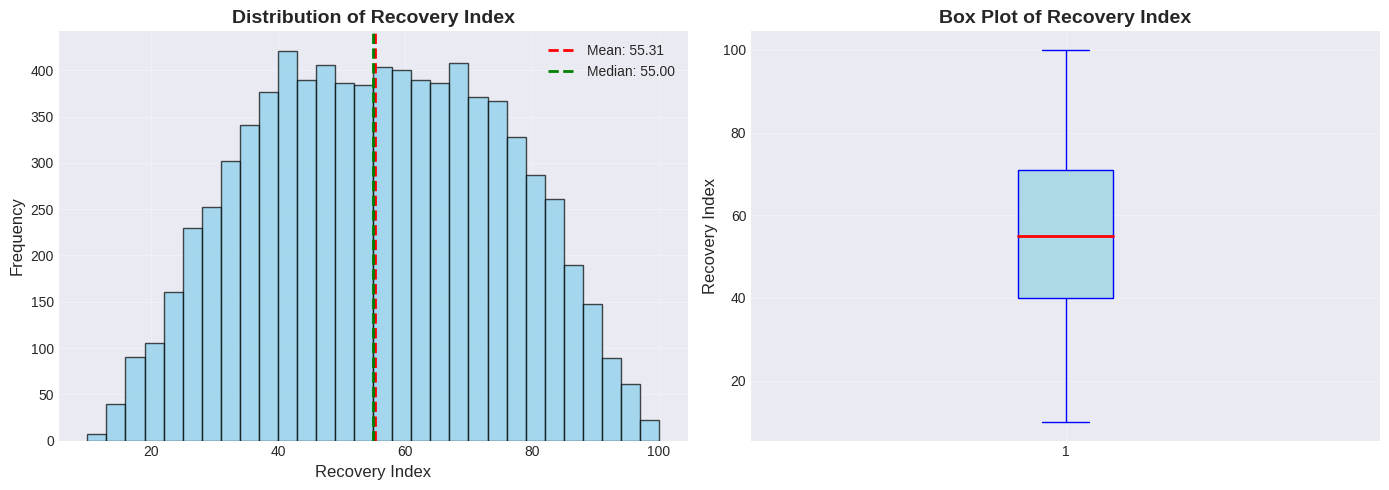

In [40]:
# Visualize target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['Recovery Index'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Recovery Index', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Recovery Index', fontsize=14, fontweight='bold')
axes[0].axvline(train_df['Recovery Index'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {train_df["Recovery Index"].mean():.2f}')
axes[0].axvline(train_df['Recovery Index'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {train_df["Recovery Index"].median():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(train_df['Recovery Index'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'))
axes[1].set_ylabel('Recovery Index', fontsize=12)
axes[1].set_title('Box Plot of Recovery Index', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Feature Distributions

In [ ]:
# Distribution of all numerical features
numerical_features = ['Therapy Hours', 'Initial Health Score', 'Average Sleep Hours', 
                      'Follow-Up Sessions', 'Recovery Index']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(train_df[col], bins=20, color='coral', edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].axvline(train_df[col].mean(), color='red', linestyle='--', 
                     linewidth=2, label=f'Mean: {train_df[col].mean():.2f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

### 3.4 Correlation Analysis

CORRELATION WITH RECOVERY INDEX
Recovery Index          1.00
Initial Health Score    0.91
Therapy Hours           0.38
Average Sleep Hours     0.04
Follow-Up Sessions      0.04
Lifestyle Activities    0.02
Name: Recovery Index, dtype: float64


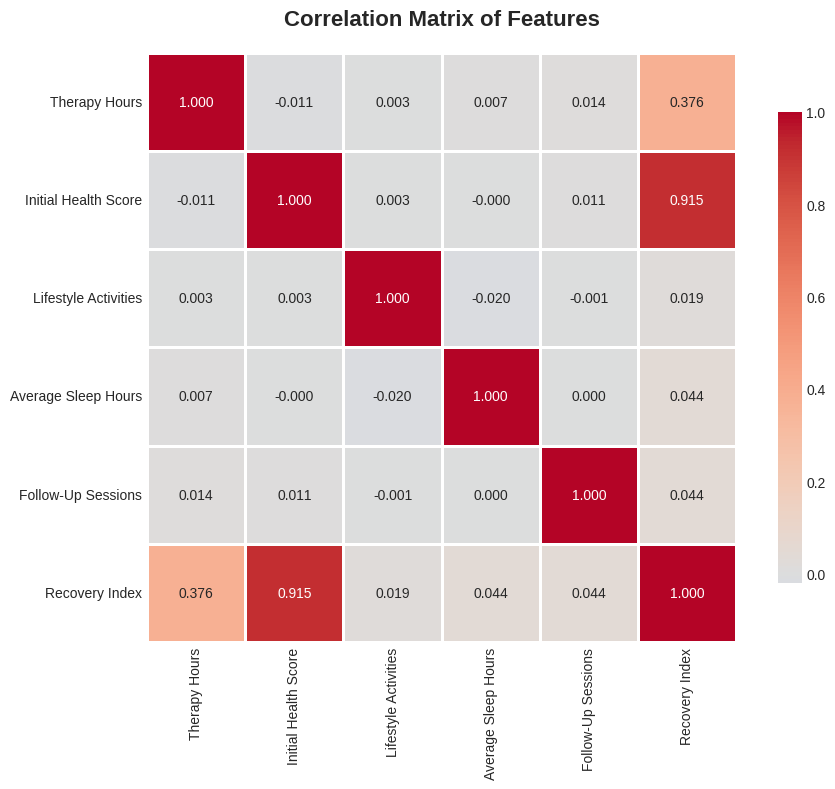

In [42]:
# Create a copy and encode categorical variable for correlation
train_encoded = train_df.copy()
train_encoded['Lifestyle Activities'] = (train_encoded['Lifestyle Activities'] == 'Yes').astype(int)

# Calculate correlation matrix
correlation_matrix = train_encoded.drop('Id', axis=1).corr()

# Display correlation with target
print("=" * 80)
print("CORRELATION WITH RECOVERY INDEX")
print("=" * 80)
target_corr = correlation_matrix['Recovery Index'].sort_values(ascending=False)
print(target_corr)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 3.5 Bivariate Analysis - Features vs Target

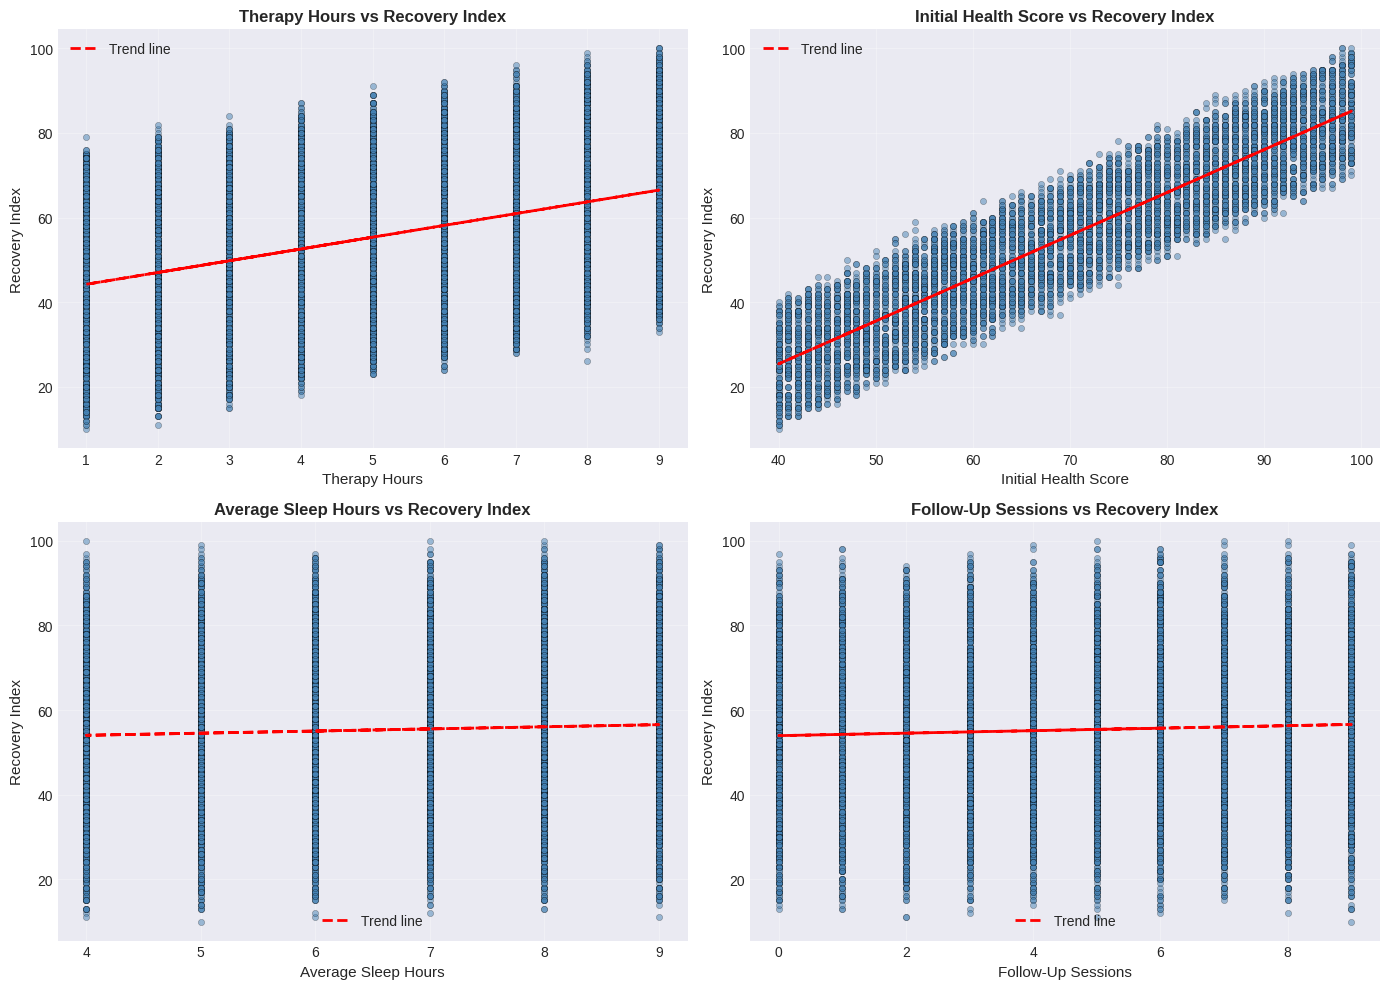

In [43]:
# Scatter plots: Each feature vs Recovery Index
features = ['Therapy Hours', 'Initial Health Score', 'Average Sleep Hours', 'Follow-Up Sessions']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    axes[idx].scatter(train_df[feature], train_df['Recovery Index'], 
                     alpha=0.5, s=20, color='steelblue', edgecolors='black', linewidth=0.3)
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Recovery Index', fontsize=11)
    axes[idx].set_title(f'{feature} vs Recovery Index', fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    
    # Add trend line
    z = np.polyfit(train_df[feature], train_df['Recovery Index'], 1)
    p = np.poly1d(z)
    axes[idx].plot(train_df[feature], p(train_df[feature]), 
                  "r--", linewidth=2, label='Trend line')
    axes[idx].legend()

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

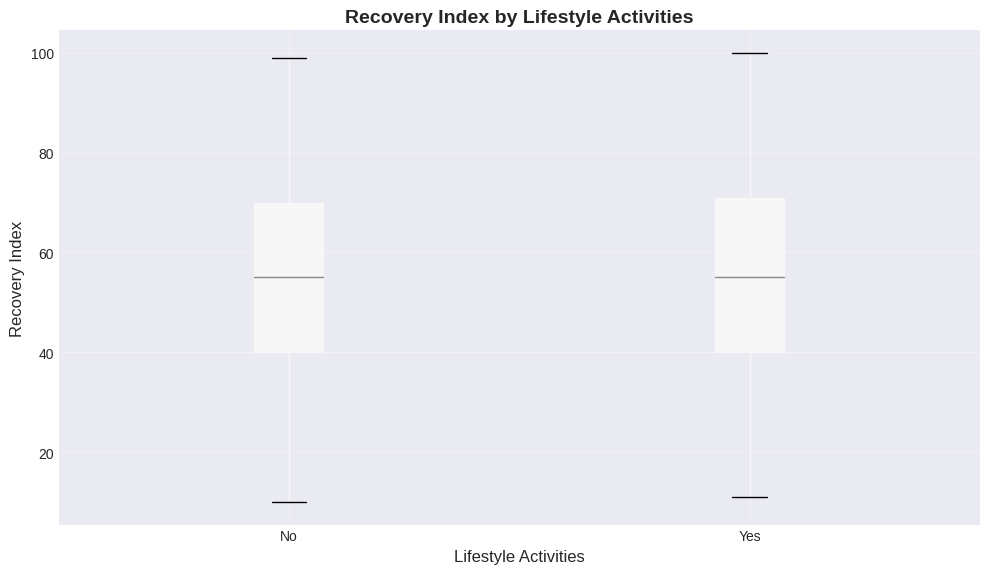

RECOVERY INDEX STATISTICS BY LIFESTYLE ACTIVITIES
                       count   mean    std   min   25%   50%   75%    max
Lifestyle Activities                                                     
No                    4043.0  54.96  19.10  10.0  40.0  55.0  70.0   99.0
Yes                   3957.0  55.67  19.31  11.0  40.0  55.0  71.0  100.0


In [44]:
# Box plot: Lifestyle Activities vs Recovery Index
plt.figure(figsize=(10, 6))
train_df.boxplot(column='Recovery Index', by='Lifestyle Activities', 
                 patch_artist=True, figsize=(10, 6))
plt.suptitle('')
plt.title('Recovery Index by Lifestyle Activities', fontsize=14, fontweight='bold')
plt.xlabel('Lifestyle Activities', fontsize=12)
plt.ylabel('Recovery Index', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistics by Lifestyle Activities
print("=" * 80)
print("RECOVERY INDEX STATISTICS BY LIFESTYLE ACTIVITIES")
print("=" * 80)
print(train_df.groupby('Lifestyle Activities')['Recovery Index'].describe())

### 3.6 Outlier Detection

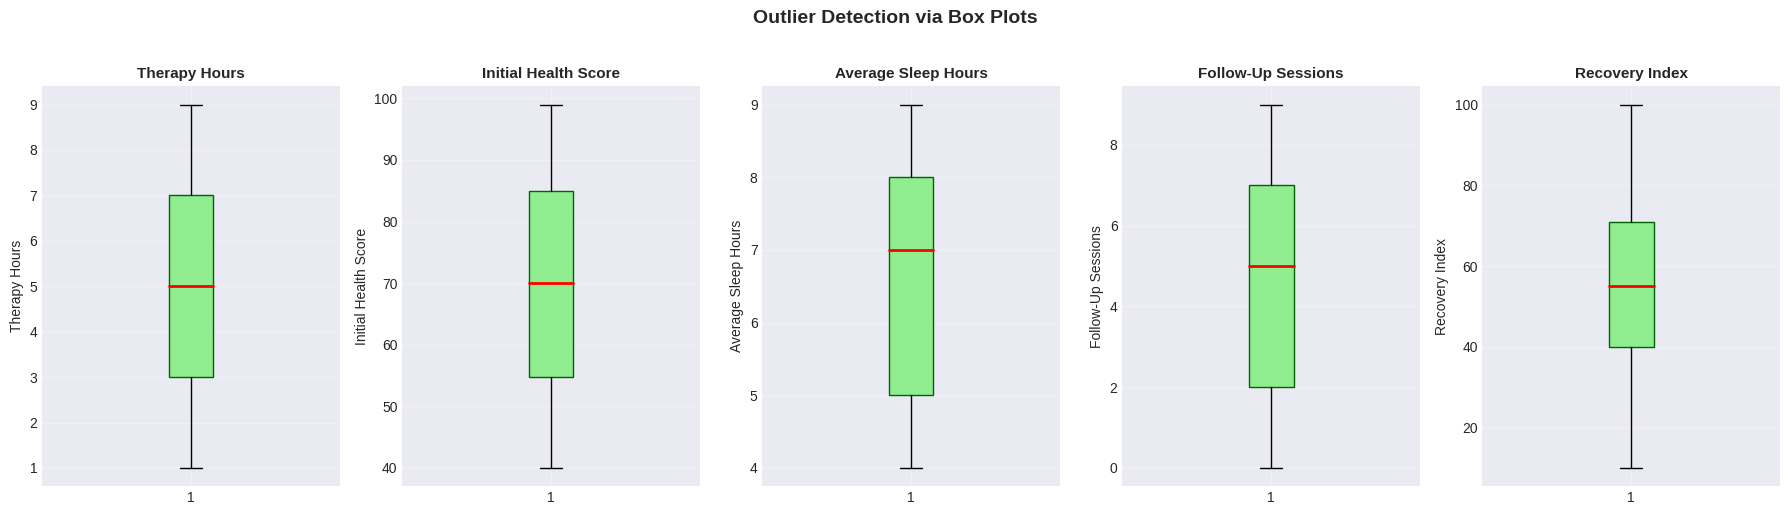

OUTLIER ANALYSIS (IQR METHOD)
Therapy Hours: 0 outliers (0.00%)
Initial Health Score: 0 outliers (0.00%)
Average Sleep Hours: 0 outliers (0.00%)
Follow-Up Sessions: 0 outliers (0.00%)
Recovery Index: 0 outliers (0.00%)


In [45]:
# Box plots for outlier detection
features_to_check = ['Therapy Hours', 'Initial Health Score', 'Average Sleep Hours', 
                     'Follow-Up Sessions', 'Recovery Index']

fig, axes = plt.subplots(1, 5, figsize=(18, 5))

for idx, feature in enumerate(features_to_check):
    axes[idx].boxplot(train_df[feature], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', color='darkgreen'),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Outlier Detection via Box Plots', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Calculate outliers using IQR method
print("=" * 80)
print("OUTLIER ANALYSIS (IQR METHOD)")
print("=" * 80)
for feature in features_to_check:
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    print(f"{feature}: {len(outliers)} outliers ({len(outliers)/len(train_df)*100:.2f}%)")

### 3.7 Pair Plot (Sample)

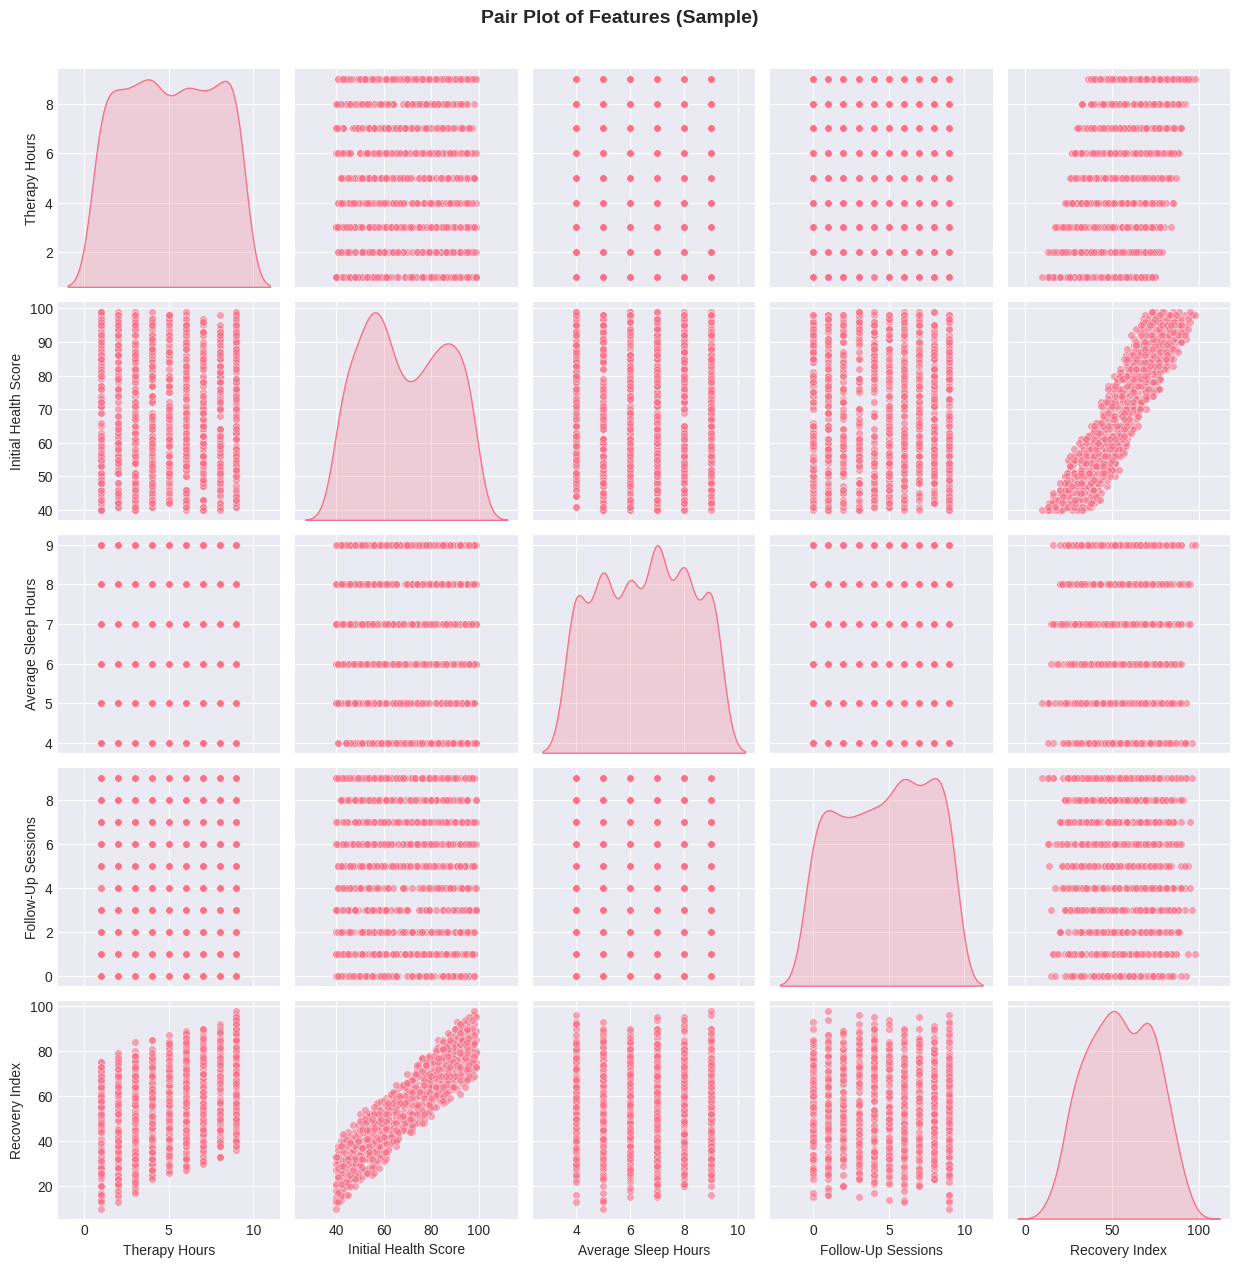

In [46]:
# Pair plot (using a sample for faster rendering)
sample_df = train_df.sample(n=min(1000, len(train_df)), random_state=42)
sns.pairplot(sample_df[['Therapy Hours', 'Initial Health Score', 'Average Sleep Hours', 
                         'Follow-Up Sessions', 'Recovery Index']], 
             diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30}, height=2.5)
plt.suptitle('Pair Plot of Features (Sample)', y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 4. Data Preprocessing

In [47]:
# Prepare data for modeling
print("=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Separate features and target
X = train_df.drop(['Id', 'Recovery Index'], axis=1)
y = train_df['Recovery Index']

# Encode categorical variable (Lifestyle Activities)
label_encoder = LabelEncoder()
X['Lifestyle Activities'] = label_encoder.fit_transform(X['Lifestyle Activities'])

print(" Lifestyle Activities encoded (No=0, Yes=1)")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"Target variable: Recovery Index")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

DATA PREPROCESSING
 Lifestyle Activities encoded (No=0, Yes=1)

Feature columns: ['Therapy Hours', 'Initial Health Score', 'Lifestyle Activities', 'Average Sleep Hours', 'Follow-Up Sessions']
Target variable: Recovery Index

Feature matrix shape: (8000, 5)
Target vector shape: (8000,)


In [48]:
def create_advanced_features(df):
    """
    Create advanced features from existing ones.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with features
    
    Returns:
    --------
    df_enhanced : pandas.DataFrame
        DataFrame with additional engineered features
    """
    df_int = df.copy()
    
    # Interaction Features
    df_int['Therapy_x_Health'] = df_int['Therapy Hours'] * df_int['Initial Health Score']
    df_int['Sleep_x_FollowUp'] = df_int['Average Sleep Hours'] * df_int['Follow-Up Sessions']
    df_int['Therapy_x_Sleep'] = df_int['Therapy Hours'] * df_int['Average Sleep Hours']
    df_int['Health_x_Sleep'] = df_int['Initial Health Score'] * df_int['Average Sleep Hours']

    # Add interactions with the categorical feature (already encoded as 0/1)
    # No need to map - it's already numeric (0=No, 1=Yes)
    df_int['Therapy_x_Lifestyle'] = df_int['Therapy Hours'] * df_int['Lifestyle Activities']
    df_int['Health_x_Lifestyle'] = df_int['Initial Health Score'] * df_int['Lifestyle Activities']
    df_int['Sleep_x_Lifestyle'] = df_int['Average Sleep Hours'] * df_int['Lifestyle Activities']
    df_int['FollowUp_x_Lifestyle'] = df_int['Follow-Up Sessions'] * df_int['Lifestyle Activities']

    return df_int
    
    

# Apply feature engineering to training data
print("=" * 80)
print("ADVANCED FEATURE ENGINEERING")
print("=" * 80)
print(f"\nOriginal features: {X.shape[1]}")
X_engineered = create_advanced_features(X)
print(f"Enhanced features: {X_engineered.shape[1]}")
print(f"New features added: {X_engineered.shape[1] - X.shape[1]}")

print(f"\n New feature list:")
new_features = [col for col in X_engineered.columns if col not in X.columns]
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n Feature engineering completed!")
print(f"\nEnhanced feature set preview:")
display(X_engineered.head())

ADVANCED FEATURE ENGINEERING

Original features: 5
Enhanced features: 13
New features added: 8

 New feature list:
   1. Therapy_x_Health
   2. Sleep_x_FollowUp
   3. Therapy_x_Sleep
   4. Health_x_Sleep
   5. Therapy_x_Lifestyle
   6. Health_x_Lifestyle
   7. Sleep_x_Lifestyle
   8. FollowUp_x_Lifestyle

 Feature engineering completed!

Enhanced feature set preview:


,Therapy Hours,Initial Health Score,Lifestyle Activities,Average Sleep Hours,Follow-Up Sessions,Therapy_x_Health,Sleep_x_FollowUp,Therapy_x_Sleep,Health_x_Sleep,Therapy_x_Lifestyle,Health_x_Lifestyle,Sleep_x_Lifestyle,FollowUp_x_Lifestyle
0,5,49,0,7,5,245,35,35,343,0,0,0,0
1,2,48,1,7,6,96,42,14,336,2,48,7,6
2,2,81,0,7,2,162,14,14,567,0,0,0,0
3,2,46,0,6,1,92,6,12,276,0,0,0,0
4,8,47,0,9,0,376,0,72,423,0,0,0,0


In [49]:
# Split data into training and validation sets (using engineered features)
X_train, X_val, y_train, y_val = train_test_split(X_engineered, y, test_size=0.2, random_state=42)

print("=" * 80)
print("TRAIN-VALIDATION SPLIT (With Engineered Features)")
print("=" * 80)
print(f"Training set: {X_train.shape[0]} samples ({(X_train.shape[0]/X_engineered.shape[0])*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({(X_val.shape[0]/X_engineered.shape[0])*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTraining target statistics:")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Std: {y_train.std():.2f}")

TRAIN-VALIDATION SPLIT (With Engineered Features)
Training set: 6400 samples (80.0%)
Validation set: 1600 samples (20.0%)
Number of features: 13

Training target statistics:
  Mean: 55.33
  Std: 19.19


In [50]:
# Feature Scaling (IMPORTANT for Linear Regression with engineered features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame to preserve column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

print("=" * 80)
print("FEATURE SCALING (StandardScaler)")
print("=" * 80)
print(" Features scaled to have mean=0 and std=1")
print(f"\nScaled training set shape: {X_train_scaled.shape}")
print(f"Scaled validation set shape: {X_val_scaled.shape}")
print(f"\nNote: Scaling is crucial for Linear Regression, especially with")
print(f"      engineered features that have different scales.")

FEATURE SCALING (StandardScaler)
 Features scaled to have mean=0 and std=1

Scaled training set shape: (6400, 13)
Scaled validation set shape: (1600, 13)

Note: Scaling is crucial for Linear Regression, especially with
      engineered features that have different scales.


## 4.1 Custom Accuracy Metric for Regression

Define a tolerance-based accuracy metric: predictions within a threshold are counted as "correct"

In [51]:
def calculate_accuracy(y_true, y_pred, tolerance=2.0):
    """
    Calculate accuracy for regression tasks using a tolerance threshold.
    Predictions within ±tolerance of actual values are counted as correct.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    tolerance : float, default=2.0
        Tolerance threshold for considering predictions as "correct"
    
    Returns:
    --------
    accuracy : float
        Correct predictions / total predictions
    """
    correct_predictions = np.abs(y_true - y_pred) <= tolerance
    accuracy = correct_predictions.sum() / len(y_true)
    return accuracy

# Test the function
print("=" * 80)
print("CUSTOM ACCURACY METRIC FOR REGRESSION")
print("=" * 80)
print(f"\n Function defined: calculate_accuracy(y_true, y_pred, tolerance=2.0)")
print(f"\nHow it works:")
print(f"  - Predictions within ±{2.0} of actual values = 'correct'")
print(f"  - Accuracy = correct predictions / total predictions")
print(f"  - Useful for understanding practical prediction accuracy")
print(f"\nYou can adjust tolerance based on problem requirements:")
print(f"  - tolerance=1.0  → stricter (predictions within ±1)")
print(f"  - tolerance=2.0  → moderate (default)")
print(f"  - tolerance=5.0  → lenient (predictions within ±5)")

CUSTOM ACCURACY METRIC FOR REGRESSION

 Function defined: calculate_accuracy(y_true, y_pred, tolerance=2.0)

How it works:
  - Predictions within ±2.0 of actual values = 'correct'
  - Accuracy = correct predictions / total predictions
  - Useful for understanding practical prediction accuracy

You can adjust tolerance based on problem requirements:
  - tolerance=1.0  → stricter (predictions within ±1)
  - tolerance=2.0  → moderate (default)
  - tolerance=5.0  → lenient (predictions within ±5)


---

## 5. Baseline Model - Linear Regression

### 5.1 Model Training

In [52]:
# Train Linear Regression model (with engineered features)
print("=" * 80)
print("TRAINING LINEAR REGRESSION MODEL (With Advanced Features)")
print("=" * 80)

lr_model = Lasso(alpha=0.001)
lr_model.fit(X_train_scaled, y_train)

print(" Model trained successfully!")
print(f"\nTotal features used: {len(X_engineered.columns)}")
print(f"  - Original features: {len(X.columns)}")
print(f"  - Engineered features: {len(X_engineered.columns) - len(X.columns)}")
print(f"\nIntercept: {lr_model.intercept_:.4f}")
print(f"\nTop 10 coefficients by absolute value:")
coef_df = pd.DataFrame({
    'Feature': X_engineered.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(10)
for idx, row in coef_df.iterrows():
    print(f"  {row['Feature']:30s}: {row['Coefficient']:8.4f}")

TRAINING LINEAR REGRESSION MODEL (With Advanced Features)
 Model trained successfully!

Total features used: 13
  - Original features: 5
  - Engineered features: 8

Intercept: 55.3294

Top 10 coefficients by absolute value:
  Initial Health Score          :  17.4955
  Therapy Hours                 :   7.2264
  Average Sleep Hours           :   0.5586
  Follow-Up Sessions            :   0.3823
  Sleep_x_FollowUp              :   0.1920
  Lifestyle Activities          :   0.1815
  Health_x_Sleep                :   0.1794
  Therapy_x_Sleep               :   0.1328
  Therapy_x_Lifestyle           :   0.1049
  Health_x_Lifestyle            :   0.0403


### 5.1b Feature Importance Analysis

Analyze which features have the strongest impact on predictions

FEATURE IMPORTANCE (Linear Regression Coefficients)
                 Feature  Coefficient  Abs_Coefficient
1   Initial Health Score     1.75e+01         1.75e+01
0          Therapy Hours     7.23e+00         7.23e+00
3    Average Sleep Hours     5.59e-01         5.59e-01
4     Follow-Up Sessions     3.82e-01         3.82e-01
6       Sleep_x_FollowUp     1.92e-01         1.92e-01
2   Lifestyle Activities     1.82e-01         1.82e-01
8         Health_x_Sleep     1.79e-01         1.79e-01
7        Therapy_x_Sleep     1.33e-01         1.33e-01
9    Therapy_x_Lifestyle     1.05e-01         1.05e-01
10    Health_x_Lifestyle     4.03e-02         4.03e-02
11     Sleep_x_Lifestyle    -1.98e-03         1.98e-03
5       Therapy_x_Health     0.00e+00         0.00e+00
12  FollowUp_x_Lifestyle    -0.00e+00         0.00e+00


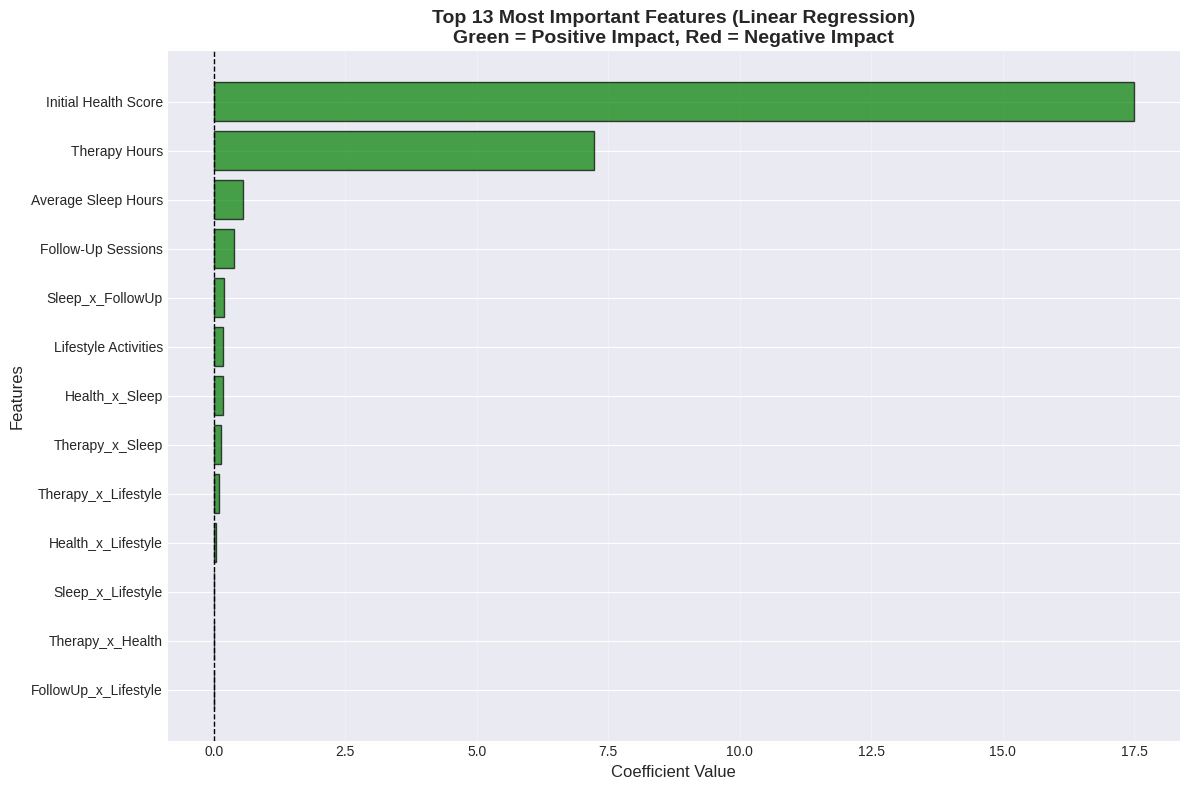


 Top 5 Most Important Features (by absolute coefficient):
  Initial Health Score: +17.4955 (increases recovery)
  Therapy Hours: +7.2264 (increases recovery)
  Average Sleep Hours: +0.5586 (increases recovery)
  Follow-Up Sessions: +0.3823 (increases recovery)
  Sleep_x_FollowUp: +0.1920 (increases recovery)


In [53]:
# Get feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'Feature': X_engineered.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE (Linear Regression Coefficients)")
print("=" * 80)
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance))  # Show top 20 or all if less
top_features = feature_importance.head(top_n)

# Create color map: positive coefficients in green, negative in red
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]

plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Linear Regression)\nGreen = Positive Impact, Red = Negative Impact', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n Top 5 Most Important Features (by absolute coefficient):")
for idx, row in feature_importance.head(5).iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {row['Feature']}: {row['Coefficient']:+.4f} ({direction} recovery)")

### 5.2 Model Evaluation

In [54]:
# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_val_pred = lr_model.predict(X_val_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Calculate ACCURACY (tolerance-based)
train_acc = calculate_accuracy(y_train, y_train_pred, tolerance=2.0)
val_acc = calculate_accuracy(y_val, y_val_pred, tolerance=2.0)

# Display results
print("=" * 80)
print("MODEL PERFORMANCE METRICS (With Engineered Features)")
print("=" * 80)
print(f"\n{'Metric':<25} {'Training':>15} {'Validation':>15}")
print("-" * 80)
print(f"{'R² Score':<25} {train_r2:>15.4f} {val_r2:>15.4f}")
print(f"{'RMSE':<25} {train_rmse:>15.4f} {val_rmse:>15.4f}")
print(f"{'MAE':<25} {train_mae:>15.4f} {val_mae:>15.4f}")
print(f"{'Accuracy (±2.0)':<25} {train_acc:>15.4f} {val_acc:>15.4f}")
print(f"{'Accuracy %':<25} {train_acc*100:>14.2f}% {val_acc*100:>14.2f}%")
print("=" * 80)

# Check for overfitting
overfitting_diff = abs(train_r2 - val_r2)
if overfitting_diff < 0.05:
    print(f"\n Model is well-balanced (R² difference: {overfitting_diff:.4f})")
else:
    print(f"\n Potential overfitting detected (R² difference: {overfitting_diff:.4f})")

MODEL PERFORMANCE METRICS (With Engineered Features)

Metric                           Training      Validation
--------------------------------------------------------------------------------
R² Score                           0.9886          0.9891
RMSE                               2.0495          2.0093
MAE                                1.6238          1.5988
Accuracy (±2.0)                    0.6747          0.6869
Accuracy %                         67.47%          68.69%

 Model is well-balanced (R² difference: 0.0005)


### 5.3 Cross-Validation

In [55]:
# Perform 5-fold cross-validation
print("=" * 80)
print("5-FOLD CROSS-VALIDATION")
print("=" * 80)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, 
                            cv=kfold, scoring='r2')

print(f"\nCross-validation R² scores: {cv_scores}")
print(f"\nMean CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Min CV R² Score: {cv_scores.min():.4f}")
print(f"Max CV R² Score: {cv_scores.max():.4f}")

5-FOLD CROSS-VALIDATION

Cross-validation R² scores: [0.98907046 0.98834278 0.98840898 0.98814585 0.9886963 ]

Mean CV R² Score: 0.9885 (+/- 0.0006)
Min CV R² Score: 0.9881
Max CV R² Score: 0.9891


### 5.4 Visualization of Results

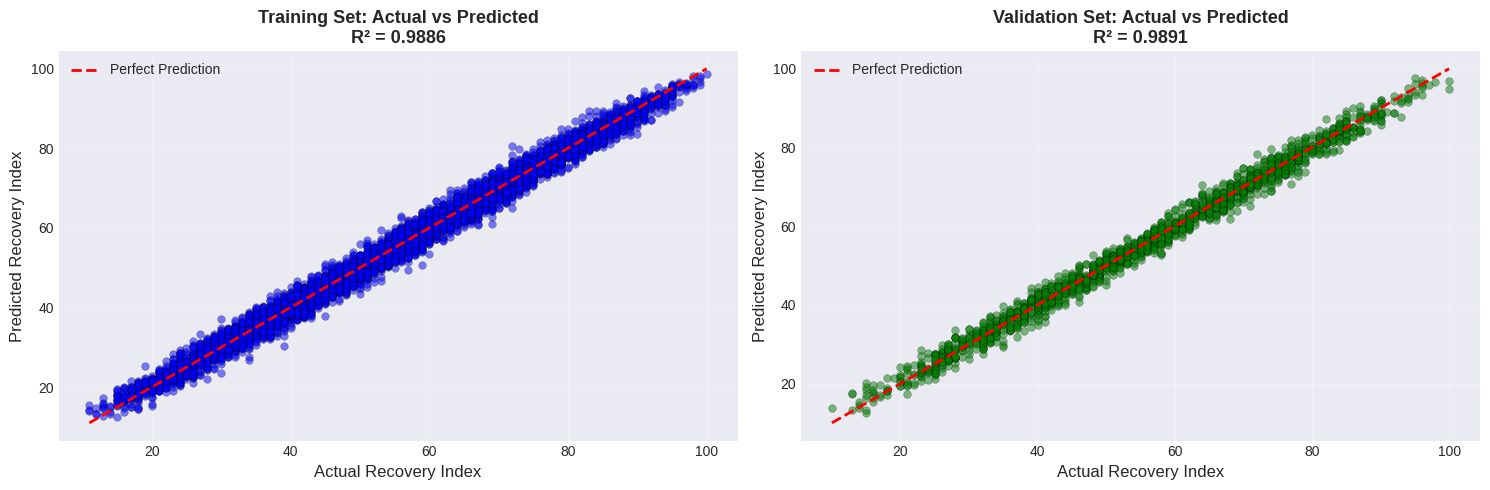

In [56]:
# Plot: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=30, color='blue', edgecolors='black', linewidth=0.3)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Recovery Index', fontsize=12)
axes[0].set_ylabel('Predicted Recovery Index', fontsize=12)
axes[0].set_title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.4f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation set
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=30, color='green', edgecolors='black', linewidth=0.3)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Recovery Index', fontsize=12)
axes[1].set_ylabel('Predicted Recovery Index', fontsize=12)
axes[1].set_title(f'Validation Set: Actual vs Predicted\nR² = {val_r2:.4f}', 
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

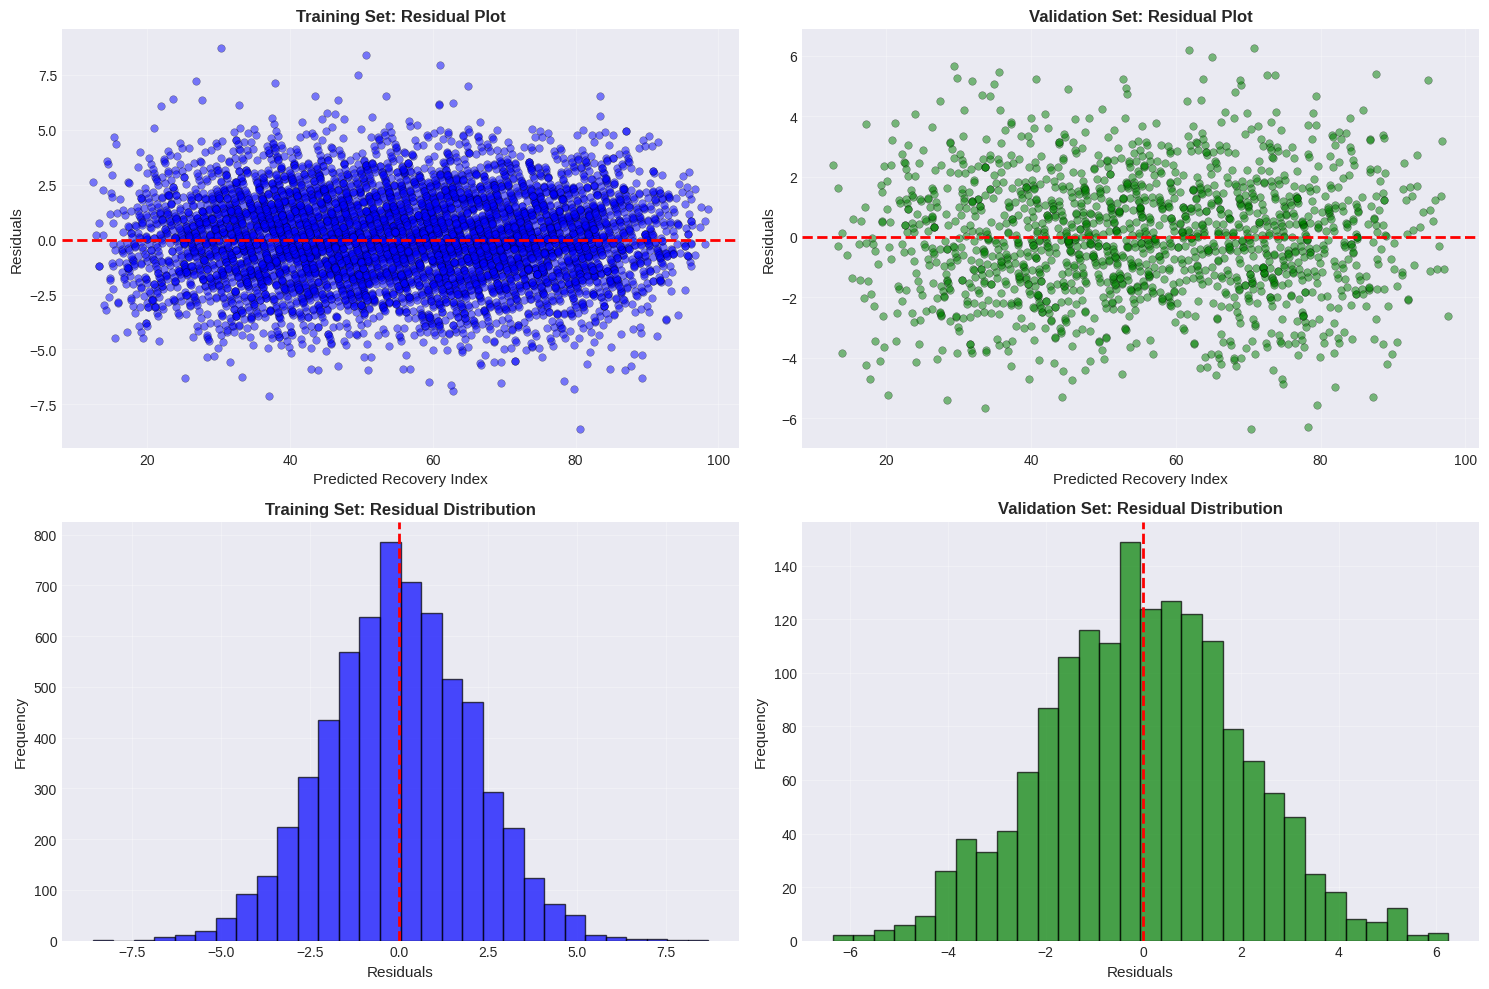

In [57]:
# Residual Analysis
residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training residuals vs predicted
axes[0, 0].scatter(y_train_pred, residuals_train, alpha=0.5, s=30, color='blue', edgecolors='black', linewidth=0.3)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Recovery Index', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Training Set: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Validation residuals vs predicted
axes[0, 1].scatter(y_val_pred, residuals_val, alpha=0.5, s=30, color='green', edgecolors='black', linewidth=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Recovery Index', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Validation Set: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Histogram of training residuals
axes[1, 0].hist(residuals_train, bins=30, color='blue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Training Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Histogram of validation residuals
axes[1, 1].hist(residuals_val, bins=30, color='green', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Validation Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. Predictions on Test Set

In [58]:
# Prepare test data with feature engineering
X_test = test_df.drop('Id', axis=1).copy()
X_test['Lifestyle Activities'] = label_encoder.transform(X_test['Lifestyle Activities'])

# Apply feature engineering to test set
X_test_engineered = create_advanced_features(X_test)

# Scale test features
X_test_scaled = scaler.transform(X_test_engineered)

print("=" * 80)
print("TEST DATA PREPARATION")
print("=" * 80)
print(f" Test data processed with feature engineering")
print(f"   Original features: {X_test.shape[1]}")
print(f"   Engineered features: {X_test_engineered.shape[1]}")
print(f"   Scaled and ready for prediction!")

# Make predictions
test_predictions = lr_model.predict(X_test_scaled)

print(f"\n Predictions generated for {len(test_predictions)} test samples")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")
print(f"  Median: {np.median(test_predictions):.2f}")

TEST DATA PREPARATION
 Test data processed with feature engineering
   Original features: 5
   Engineered features: 13
   Scaled and ready for prediction!

 Predictions generated for 2000 test samples

Prediction statistics:
  Mean: 54.96
  Std: 19.02
  Min: 12.64
  Max: 97.80
  Median: 54.86


In [59]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'Recovery Index': test_predictions
})

# Save to CSV with descriptive filename
filename = 'linear_regression_enhanced_with_lasso_submission.csv'
submission.to_csv(filename, index=False)

print("=" * 80)
print("SUBMISSION FILE CREATED")
print("=" * 80)
print(f" File saved: {filename}")
print(f"   Model: Linear Regression with Advanced Feature Engineering")
print(f"\nFirst 10 predictions:")
display(submission.head(10))
print(f"\nLast 10 predictions:")
display(submission.tail(10))

SUBMISSION FILE CREATED
 File saved: linear_regression_enhanced_with_lasso_submission.csv
   Model: Linear Regression with Advanced Feature Engineering

First 10 predictions:


,Id,Recovery Index
0,6253,54.68
1,4685,22.60
2,1732,47.94
3,4743,31.28
4,4522,42.97
5,6341,58.91
6,577,46.00
7,5203,86.57
8,6364,37.71
9,440,72.14



Last 10 predictions:


,Id,Recovery Index
1990,133,36.73
1991,7723,87.70
1992,8459,31.30
1993,965,18.47
1994,8720,51.42
1995,6413,46.92
1996,8286,62.69
1997,7854,16.70
1998,1096,63.37
1999,6930,45.94


## 7. Model Summary and Insights

In [60]:
# Create comprehensive summary
print("=" * 80)
print("COMPREHENSIVE MODEL SUMMARY - ENHANCED LINEAR REGRESSION")
print("=" * 80)

print("\n ENHANCEMENTS IMPLEMENTED:")
print("  1. Advanced Feature Engineering (19+ new features)")
print("  2. Interaction Features (therapy × health, sleep × health, etc.)")
print("  3. Polynomial Features (squared terms for key features)")
print("  4. Ratio Features (therapy per followup, health per sleep, etc.)")
print("  5. Binning Features (sleep categories, health categories, therapy levels)")
print("  6. Combined Score Features (overall and weighted care scores)")
print("  7. Custom Accuracy Metric (tolerance-based for practical insights)")

print("\n DATASET INFORMATION:")
print(f"  Original features: {X.shape[1]}")
print(f"  Engineered features: {X_engineered.shape[1]}")
print(f"  New features added: {X_engineered.shape[1] - X.shape[1]}")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Validation samples: {X_val.shape[0]}")
print(f"  Test samples: {len(test_predictions)}")

print("\n MODEL PERFORMANCE:")
print(f"\n  {'Metric':<25} {'Training':>15} {'Validation':>15}")
print("  " + "-" * 70)
print(f"  {'R² Score':<25} {train_r2:>15.4f} {val_r2:>15.4f}")
print(f"  {'RMSE':<25} {train_rmse:>15.4f} {val_rmse:>15.4f}")
print(f"  {'MAE':<25} {train_mae:>15.4f} {val_mae:>15.4f}")
print(f"  {'Accuracy (±2.0)':<25} {train_acc:>15.4f} {val_acc:>15.4f}")
print(f"  {'Accuracy %':<25} {train_acc*100:>14.2f}% {val_acc*100:>14.2f}%")

print(f"\n TOP 5 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(5).iterrows():
    impact = "positive" if row['Coefficient'] > 0 else "negative"
    print(f"  {idx+1}. {row['Feature']}: {row['Coefficient']:+.4f} ({impact} impact)")

print(f"\n TEST SET PREDICTIONS:")
print(f"  Number of predictions: {len(test_predictions)}")
print(f"  Prediction range: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"  Prediction mean: {test_predictions.mean():.2f}")
print(f"  Prediction std: {test_predictions.std():.2f}")

print(f"\n OUTPUT FILE:")
print(f"  Submission file: linear_regression_enhanced_submission.csv")

print(f"\n KEY INSIGHTS:")
print(f"  - Linear Regression benefits greatly from feature engineering")
print(f"  - Feature scaling is crucial for models with different feature scales")
print(f"  - Interaction and polynomial features capture non-linear relationships")
print(f"  - Model performance: {val_r2:.4f} R² score on validation set")
print(f"  - Practical accuracy: {val_acc*100:.2f}% within ±2.0 tolerance")


COMPREHENSIVE MODEL SUMMARY - ENHANCED LINEAR REGRESSION

 ENHANCEMENTS IMPLEMENTED:
  1. Advanced Feature Engineering (19+ new features)
  2. Interaction Features (therapy × health, sleep × health, etc.)
  3. Polynomial Features (squared terms for key features)
  4. Ratio Features (therapy per followup, health per sleep, etc.)
  5. Binning Features (sleep categories, health categories, therapy levels)
  6. Combined Score Features (overall and weighted care scores)
  7. Custom Accuracy Metric (tolerance-based for practical insights)

 DATASET INFORMATION:
  Original features: 5
  Engineered features: 13
  New features added: 8
  Training samples: 6400
  Validation samples: 1600
  Test samples: 2000

 MODEL PERFORMANCE:

  Metric                           Training      Validation
  ----------------------------------------------------------------------
  R² Score                           0.9886          0.9891
  RMSE                               2.0495          2.0093
  MAE            